Generate plot of SFNO-generated vs E3SMv2 distribution of precipitation.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

from fme_diags.histogram import compute_histograms, plot_time_mean_histogram
from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference

_ = xr.set_options(keep_attrs=True)

In [2]:
if not "RUN_KEY" in os.environ:
    RUN_KEY = "topo-batch_size8-max_epochs50-lr3.00e-04"
else:
    RUN_KEY = os.environ["RUN_KEY"]

In [3]:
config = load_config("preds.yaml")
run_kwargs = get_run_kwargs(config, RUN_KEY)
run_kwargs

{'path': '/pscratch/sd/j/jpduncan/ai2/datasets/2023-11-22-e3smv2-vertically-resolved-1deg-fme-dataset/output/42-years-training-set/42yrs-batch_size8-max_epochs50-lr3e-4-run4/autoregressive_predictions.nc',
 'start': '0054-01-01',
 'step_dim': 'lead',
 'step_freq': '6H',
 'calendar': 'noleap',
 'flip_lat': False,
 'chunks': {'lead': 178}}

In [4]:
ds = open_autoregressive_inference(**run_kwargs)
ds

<xarray.Dataset>
Dimensions:                                        (time: 14597, sample: 1,
                                                    source: 2, lat: 180,
                                                    lon: 360)
Coordinates:
  * time                                           (time) object 0054-01-01 0...
    init                                           (sample) object dask.array<chunksize=(1,), meta=np.ndarray>
    valid_time                                     (sample, time) object dask.array<chunksize=(1, 178), meta=np.ndarray>
  * source                                         (source) object 'target' '...
  * lat                                            (lat) float32 89.24 ... -8...
  * lon                                            (lon) float32 0.5 ... 359.5
Dimensions without coordinates: sample
Data variables: (12/49)
    surface_upward_shortwave_flux                  (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_7                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    PHIS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    T_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    U_3                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    ...                                             ...
    V_2                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    V_6                                            (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    LHFLX                                          (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    TS                                             (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    FSDS                                           (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>
    specific_total_water_4                         (source, sample, time, lat, lon) float32 dask.array<chunksize=(2, 1, 178, 180, 360), meta=np.ndarray>

In [5]:
da = ds["surface_precipitation_rate"]

with ProgressBar():
    da = da.resample(time="1D").mean("time").compute()

[########################################] | 100% Completed | 26.0s


In [6]:
hist_range = da.min().compute().item(), da.max().compute().item()

No latitude weighting:

In [7]:
%%time

precip_hist_ds = compute_histograms(da, n_bins=300, hist_range=hist_range, lat_weighted=False)
precip_hist_ds

CPU times: user 45.6 s, sys: 0 ns, total: 45.6 s
Wall time: 45.8 s


<xarray.Dataset>
Dimensions:    (source: 2, sample: 1, time: 3649, bin_id: 300, bin_edges: 301)
Coordinates:
  * source     (source) object 'target' 'prediction'
  * sample     (sample) int64 0
  * time       (time) object 0054-01-02 00:00:00 ... 0063-12-31 00:00:00
  * bin_id     (bin_id) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * bin_edges  (bin_edges) float64 -0.0002549 -0.0002263 ... 0.008306 0.008334
Data variables:
    hist       (source, sample, time, bin_id) float64 0.0 0.0 0.0 ... 0.0 0.0

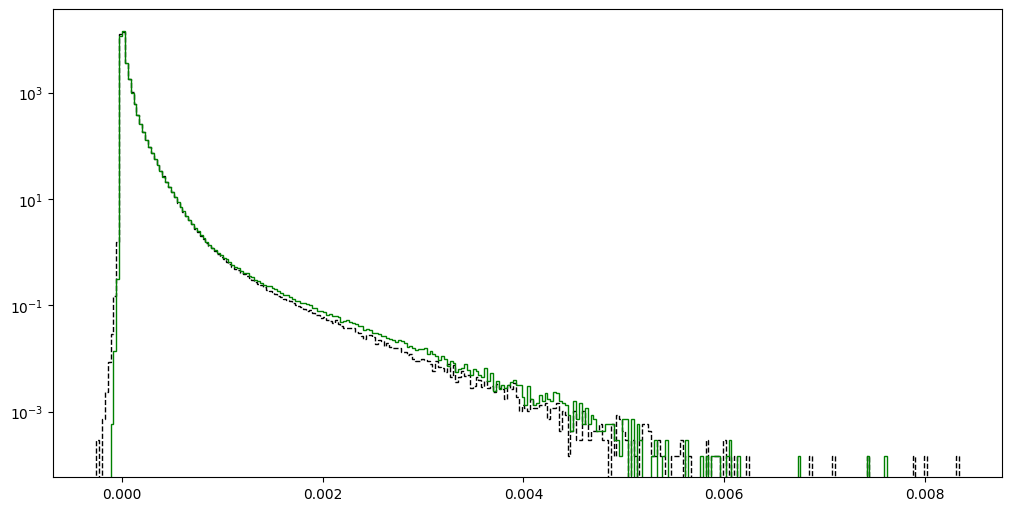

In [8]:
fig, ax = plot_time_mean_histogram(precip_hist_ds, log=True, density=True, histtype="step")
fig.show()

With latitude weighting:

In [9]:
%%time

lat_weighted_precip_hist_ds = compute_histograms(da, n_bins=300, hist_range=hist_range, lat_weighted=True)

CPU times: user 45.3 s, sys: 285 µs, total: 45.3 s
Wall time: 56.7 s


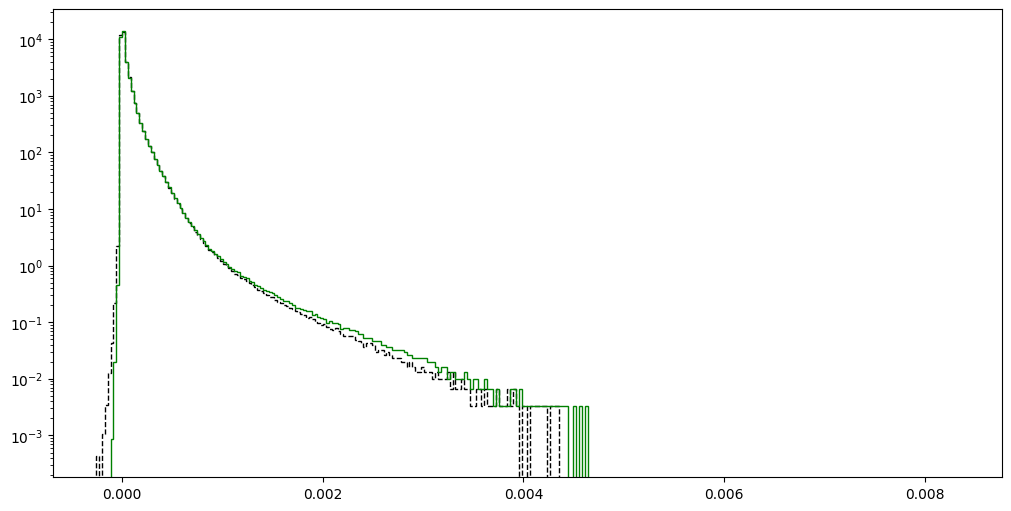

In [10]:
fig, ax = plot_time_mean_histogram(lat_weighted_precip_hist_ds, log=True, density=True, histtype="step")
fig.show()

Tropics, no latitude weighting:

In [11]:
da_tropics = da.sel(lat=slice(15, -15))
hist_range_tropics = da_tropics.min().compute().item(), da_tropics.max().compute().item()

In [12]:
%%time

precip_hist_ds_tropics = compute_histograms(da_tropics, n_bins=300, hist_range=hist_range_tropics, lat_weighted=False)
precip_hist_ds_tropics

CPU times: user 8.55 s, sys: 17.8 ms, total: 8.57 s
Wall time: 8.57 s


<xarray.Dataset>
Dimensions:    (source: 2, sample: 1, time: 3649, bin_id: 300, bin_edges: 301)
Coordinates:
  * source     (source) object 'target' 'prediction'
  * sample     (sample) int64 0
  * time       (time) object 0054-01-02 00:00:00 ... 0063-12-31 00:00:00
  * bin_id     (bin_id) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * bin_edges  (bin_edges) float64 -0.0001418 -0.0001146 ... 0.007982 0.008009
Data variables:
    hist       (source, sample, time, bin_id) float64 0.0 0.0 0.0 ... 0.0 0.0

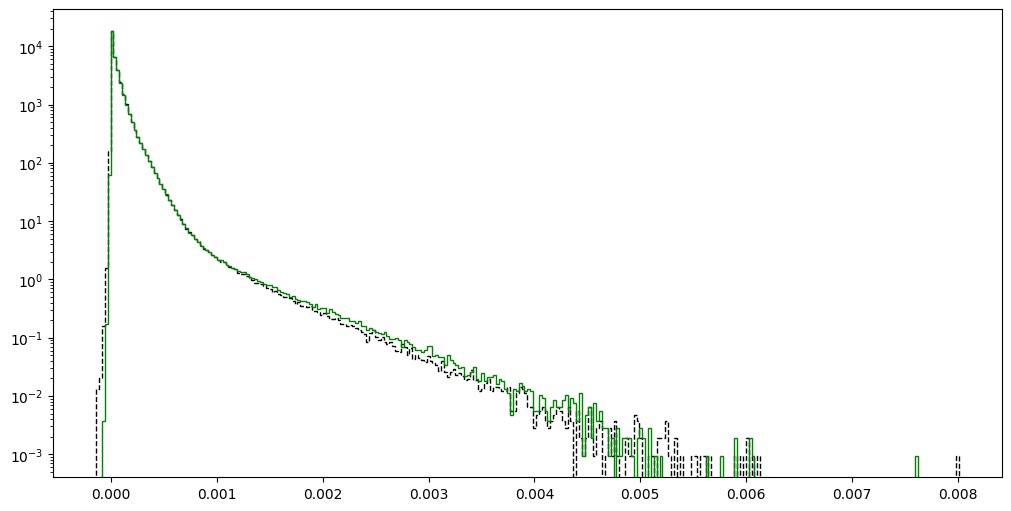

In [13]:
fig, ax = plot_time_mean_histogram(precip_hist_ds_tropics, log=True, density=True, histtype="step")
fig.show()